<a href="https://colab.research.google.com/github/copyrade/FakeNews/blob/SpaghettiCodeBranch/fake_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
%matplotlib inline

In [0]:
facts = {'okrągła Ziemia' : True, 'szczepionki i autyzm' : False}

class News(ABC):
  def __init__(self, _id, _claim=True, _pers=0.5):
    self.id = _id   # temat newsa, np. 'okrągła Ziemia'
    self.claim = _claim   # czy news mówi, że to prawda
    self.pers = _pers   # persuasiveness (parametr a lub rho z artykułu)
   
class RealNews(News):
  def __init__(self, _id, _claim=True, _pers=0.5):
    super().__init__(_id, _claim, _pers)
    self.prob = _pers if _claim == facts[_id] else 1 - _pers   # siła przekonywania newsa zależy od jego prawdziwości (nie wiedziałem, jak nazwać tę zmienną)

class FakeNews(News):
  def __init__(self,_id,  _claim=True, _pers=0.5):
    super().__init__(_id, _claim, _pers)
    self.prob = _pers   # siła przekonywania newsa nie zależy od jego prawdziwości
    
class Agent:
  def __init__(self, _beliefs):
    self.beliefs = _beliefs   # poglądy - słownik {temat: liczba od 0 do 1}
    self.faith = np.random.uniform()   # ogólna wiara w prawdziwość newsów
    self.dfaith = 0.2 * np.random.uniform()   # o ile będzie mu się zwiększać / zmniejszać wiara, jak sprawdzi, że news kłamie
    self.sociality = np.random.uniform()   # ogólne pstwo, że wyśle newsa
    self.readNews = []   # przeczytane newsy - nie sprawdza i nie wysyła ich drugi raz
    
  def checkOrNotChek(self, news):
    # takie tam, pewnie do zmiany
    belief = self.beliefs[news.id] if news.claim else 1 - self.beliefs[news.id]
    prob = 1 - min(1, self.faith * (belief + news.prob))
    return np.random.uniform() < prob
  
  def updateBeliefs(self, news, checked):
    # takie tam, pewnie do zmiany
    if checked:
      # zakładam, że jak sprawdził newsa, to poznał fakty i sobie ustawia przekonania zgodne z faktami
      self.beliefs[news.id] = 1 if facts[news.id] else 0
      if (news.claim and facts[news.id]) or (not(news.claim) and not(facts[news.id])):
        self.faith += self.dfaith
      else:
        self.faith -= self.dfaith               
    else:
      bprior = self.beliefs[news.id]
      btrust = bprior * news.pers / (bprior * news.pers + (1 - bprior) * (1 - news.pers))   # nowe przekonanie przy założeniu, że newsy są prawdziwe
      self.beliefs[news.id] = self.faith * btrust + (1 - self.faith) * bprior   # przy założeniu, że wszystko to fake newsy, przekonania się nie zmieniają -> 
                                                                                # od ogólnej wiary w newsy zależy jak bardzo zmieni przekonanie
  
  def sendOrNorSend(self, news):
    # takie tam, pewnie do zmiany
    belief = self.beliefs[news.id] if news.claim else 1 - self.beliefs[news.id]
    prob =  self.sociality * min(1, belief + news.prob)
    return np.random.uniform() < prob

In [0]:
# nie wiem, jak ładnie zaznaczać różne newsy na grafie - na razie zaznaczam dla jednego newsa, którzy agenci go czytają
def drawGraph(network, news):
  pos = nx.circular_layout(network)
  color_map = []
  for inode in network:
    if news in network.nodes[inode]['news']:
      color_map.append('blue')
    else: 
      color_map.append('green')   
  plt.figure()
  nx.draw(network, pos, node_color = color_map, with_labels = True)

Agent 12 nie sprawdza newsa okrągła Ziemia : True
Agent 12 wysyła newsa okrągła Ziemia : True
Agent 8 nie sprawdza newsa okrągła Ziemia : True
Agent 8 wysyła newsa okrągła Ziemia : True
Agent 9 nie sprawdza newsa okrągła Ziemia : True
Agent 9 wysyła newsa okrągła Ziemia : True
Agent 11 sprawdza newsa okrągła Ziemia : True
Agent 11 nie wysyła newsa okrągła Ziemia : True
Agent 2 sprawdza newsa okrągła Ziemia : True
Agent 2 wysyła newsa okrągła Ziemia : True
Agent 7 sprawdza newsa okrągła Ziemia : True
Agent 7 wysyła newsa okrągła Ziemia : True
Agent 4 sprawdza newsa okrągła Ziemia : True
Agent 4 nie wysyła newsa okrągła Ziemia : True
Agent 6 nie sprawdza newsa okrągła Ziemia : True
Agent 6 nie wysyła newsa okrągła Ziemia : True
Agent 13 sprawdza newsa okrągła Ziemia : True
Agent 13 nie wysyła newsa okrągła Ziemia : True


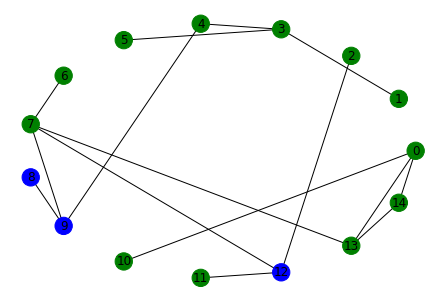

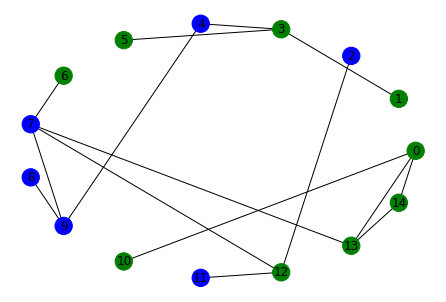

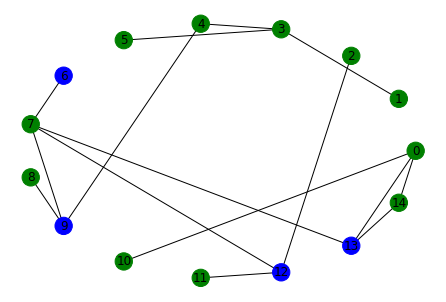

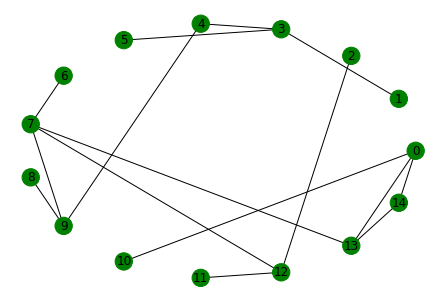

In [0]:
nnodes = 15
network = nx.watts_strogatz_graph(nnodes, 3, 0.5)
for inode in network:
  network.nodes[inode]['agent'] = Agent({'okrągła Ziemia': np.random.uniform(), 'szczepionki i autyzm': np.random.uniform()})
  network.nodes[inode]['news'] = []

news = RealNews('okrągła Ziemia', True, 0.8)
start_inodes = np.random.choice(nnodes, 3, replace = False)
for inode in start_inodes:
  network.nodes[inode]['news'] = [news]

drawGraph(network, news)

news_inodes = start_inodes
for iter in range(10):
  news_inodes_new = []
  for inode in news_inodes:
    for news in network.nodes[inode]['news']:
      agent = network.nodes[inode]['agent']
      if news in agent.readNews:
        network.nodes[inode]['news'].remove(news)
        continue
      check = agent.checkOrNotChek(news)
      if (check):
        print('Agent', inode, 'sprawdza newsa', news.id, ':', news.claim)
      else:
        print('Agent', inode, 'nie sprawdza newsa', news.id, ':', news.claim)
      agent.updateBeliefs(news, check)
      send = agent.sendOrNorSend(news)
      if (send):
        print('Agent', inode, 'wysyła newsa', news.id, ':', news.claim)
      else:
        print('Agent', inode, 'nie wysyła newsa', news.id, ':', news.claim)
      agent.readNews.append(news)
      if send:
        for new_inode in network.neighbors(inode):
          news_inodes_new.append(new_inode)
          network.nodes[new_inode]['news'].append(news)
      network.nodes[inode]['news'].remove(news)
  drawGraph(network, news)
  if not(news_inodes_new):
    break
  news_inodes = news_inodes_new